## Pipeline

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(
'https://archive.ics.uci.edu/ml/'
'machine-learning-databases'
'/breast-cancer-wisconsin/wdbc.data',
header=None
)

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

In [5]:
le = LabelEncoder()

In [6]:
y = le.fit_transform( y )

In [7]:
le.classes_

array(['B', 'M'], dtype=object)

In [8]:
le.transform( ['B', 'M'] ) # confirm the labels.

array([0, 1])

In [9]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0, stratify=y )

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [22]:
pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression()
)

In [23]:
pipeline.fit( X_train, y_train ) 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression())])

In [23]:
y_pred = pipeline.predict( X_test )

In [25]:
score = pipeline.score( X_test, y_test )

In [26]:
score

0.9298245614035088

## Cross-Validation ( Holdout & K-fold )

### Holdout

In [ ]:
'''
    * When we are trying to estimate the best hyperparamter of a model we tend to choose between
    different models with different values. The selsction of one of these model is called model 
    selection phase. In this phase, each model is tested with the Test dataset.
    Keep in mind, this particular dataset has never been used in the training process.
    To get the weights their right values we use other dataset that is a subset of the training set
    called `validation` set. 
    
    * The main disadvantage of the holdout method is it relis on a particular set to test. We should not forget
    that the performance of each model will vary depending on that dataset, and that is where K-fold method 
    comes into play.
'''

### K-Fold

In [27]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [28]:
sf = StratifiedKFold( n_splits=10 ).split( X_train, y_train )

In [30]:
scores = []
for i, (train,test) in enumerate( sf ):
    pipeline.fit( X_train[train], y_train[train] )
    score = pipeline.score( X_train[test], y_train[test] )
    scores.append(score)

In [31]:
scores

[0.9782608695652174,
 1.0,
 0.9777777777777777,
 0.9555555555555556,
 0.8888888888888888,
 0.9777777777777777,
 1.0]

In [32]:
from sklearn.model_selection import cross_val_score

In [ ]:
'''
    The `n_job` parameter could be used to utilize CPU cores.
'''

In [34]:
scores = cross_val_score( estimator=pipeline, X=X_train, y=y_train, n_jobs=1, cv=10 )

In [38]:
scores_mean = np.mean(scores)
scores_stddiv = np.std(score)

In [40]:
scores_mean

0.9647826086956522

In [41]:
scores_stddiv

0.0

## Debugging through learning curves.  

In [ ]:
'''
    By looking at the model's accuracy at two different subsets, i.e validation and training,
    we can have an idea about how is the model doing. Is it Underfitting ( high bias ), 
    overfitting ( high variance ) or just about right ?

    * A large gap between the graph of the two, training and validation, shows a sign of 
    high-variance ( overfitting ).  
    
    * While both does not have a large gap between but they are also far from the wanted
    accuracy, this indicates a sign of high bias ( underfitting ).
'''

In [43]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [126]:
pl = make_pipeline( StandardScaler(), LogisticRegression( penalty = "l2", max_iter = 10000, C = 2 ) )

In [109]:
train_size, train_score, test_score = learning_curve( estimator=pl, X = X_train, y = y_train, train_sizes=np.linspace( 0.1, 1, 10 ), cv = 10 )

In [110]:
train_mean = np.mean( train_score, axis = 1)
train_std  = np.std( train_score, axis = 1 )
test_mean = np.mean( test_score, axis = 1 )
test_std = np.std( test_score, axis = 1 )

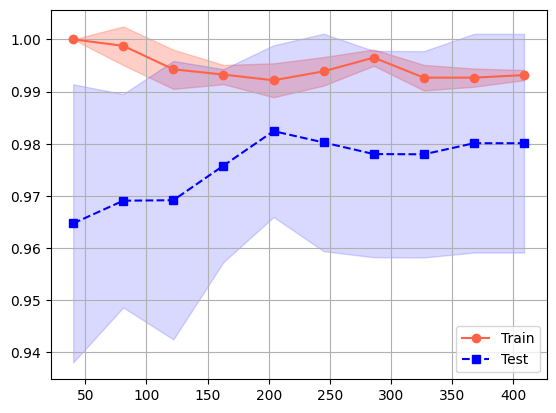

In [115]:
plt.plot( train_size, train_mean, label="Train", c = "tomato", marker="o")
plt.plot( train_size, test_mean, label="Test", c = "blue", marker="s", linestyle = '--')

plt.fill_between( train_size, train_mean + train_std, train_mean - train_std, color = "tomato", alpha=0.3 )
plt.fill_between( train_size, test_mean + test_std, test_mean - test_std, color = "blue", alpha=0.15 )

plt.legend( loc = "best" )
plt.grid()
plt.show()

## Debugging through validation curves.

In [ ]:
'''
    While learning curves technique estimates the variance and the bias by changing
    the sizes of the set, validation curves are more used while tuning the hyperparameters.
'''

In [123]:
from sklearn.model_selection import validation_curve

In [124]:
param_range = [ -0.001, -0.01 , -0.1, 1, 10, 100, 1000 ]

In [127]:
train_scores, test_scores = validation_curve( estimator = pl, X = X_train, y = y_train, param_range=param_range, 
                                              param_name="logisticregression__C", cv = 10 ) 

In [128]:
train_mean = np.mean( train_scores, axis = 1 )
train_std = np.std( train_scores, axis = 1 )
test_mean = np.mean( test_scores, axis = 1 )
test_std = np.std( test_scores, axis = 1 )

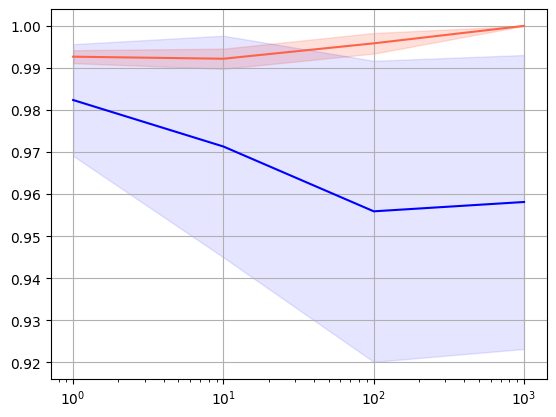

In [129]:
plt.plot( param_range, train_mean, color = "tomato", label = "train" ) 
plt.plot( param_range, test_mean, color = "blue", label = "test" ) 
plt.fill_between( param_range, train_mean + train_std, train_mean - train_std, color = "tomato", alpha = 0.2 ) 
plt.fill_between( param_range, test_mean + test_std, test_mean - test_std, color = "blue", alpha = 0.1 ) 
plt.xscale( "log" )
plt.grid()
plt.show()

## Optimize Hyperparams.

### Grid Search

In [142]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [143]:
pl_svc = make_pipeline( StandardScaler(), SVC() )

In [163]:
param_range = [0.00001, 0.0001, 0.001, 0.1, 10, 100, 1000]

In [164]:
param_grid = [
    
    { "svc__C" : param_range,
      "svc__kernel" : ["linear"] },
    
    { "svc__C" : param_range,
      "svc__gamma" : param_range,
      "svc__kernel" : ['rbf']}
]

In [165]:
gs = GridSearchCV( estimator = pl_svc, param_grid=param_grid, refit=True, scoring="accuracy", cv=10 )

In [166]:
gs.fit( X_train, y_train )

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid=[{'svc__C': [1e-05, 0.0001, 0.001, 0.1, 10, 100, 1000],
                          'svc__kernel': ['linear']},
                         {'svc__C': [1e-05, 0.0001, 0.001, 0.1, 10, 100, 1000],
                          'svc__gamma': [1e-05, 0.0001, 0.001, 0.1, 10, 100,
                                         1000],
                          'svc__kernel': ['rbf']}],
             scoring='accuracy')

In [168]:
gs.best_params_

{'svc__C': 1000, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}

In [169]:
cld = gs.best_estimator_

In [170]:
y_pred = cld.predict( X_test )

In [173]:
cld.score( X_test, y_test )

0.9824561403508771

### Randomized Search

In [ ]:
'''
    Since grid search is really expensive in real-world applicatioins, 
    randomized search domes into play. Furthermore, if the dataset is scarace 
    or ther user did not supply the right hyperparameters to tune, grid search
    will probably miss pretty good choices.

    Its main power comes from the fact that we can give it a distribtution 
    to sample from.
'''

In [174]:
import scipy

In [175]:
param_range = scipy.stats.loguniform( 0.0001, 1000.0 )

In [179]:
np.random.seed(0)
param_range.rvs(10)

array([6.94535626e-01, 1.01467174e+01, 1.65708060e+00, 6.51901951e-01,
       9.23811992e-02, 3.32092289e+00, 1.15640638e-01, 1.74747514e+02,
       5.56723205e+02, 4.83159621e-02])

In [180]:
from sklearn.model_selection import RandomizedSearchCV

In [181]:
rs = RandomizedSearchCV( estimator=pl_svc, param_distributions=param_grid,
                        scoring="accuracy", refit=True, n_iter=10, cv = 10,
                        random_state=0)

In [182]:
rs.fit( X_train, y_train )

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc', SVC())]),
                   param_distributions=[{'svc__C': [1e-05, 0.0001, 0.001, 0.1,
                                                    10, 100, 1000],
                                         'svc__kernel': ['linear']},
                                        {'svc__C': [1e-05, 0.0001, 0.001, 0.1,
                                                    10, 100, 1000],
                                         'svc__gamma': [1e-05, 0.0001, 0.001,
                                                        0.1, 10, 100, 1000],
                                         'svc__kernel': ['rbf']}],
                   random_state=0, scoring='accuracy')

In [185]:
sv = rs.best_estimator_

In [186]:
sv.score( X_test, y_test )

0.9824561403508771

In [ ]:
'''
    By elimnating some unpromising hyperparam. configs this method 
    is more effecient.
'''

In [188]:
from sklearn.experimental import enable_halving_search_cv

In [189]:
from sklearn.model_selection import HalvingRandomSearchCV

In [205]:
hrs = HalvingRandomSearchCV( estimator=pl_svc, param_distributions=param_grid,
                            refit=True, cv=10, scoring="accuracy", n_candidates="exhaust",
                            resource="n_samples", n_jobs=-1 )

In [206]:
hrs.fit( X_train, y_train )

HalvingRandomSearchCV(cv=10,
                      estimator=Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('svc', SVC())]),
                      n_jobs=-1,
                      param_distributions=[{'svc__C': [1e-05, 0.0001, 0.001,
                                                       0.1, 10, 100, 1000],
                                            'svc__kernel': ['linear']},
                                           {'svc__C': [1e-05, 0.0001, 0.001,
                                                       0.1, 10, 100, 1000],
                                            'svc__gamma': [1e-05, 0.0001, 0.001,
                                                           0.1, 10, 100, 1000],
                                            'svc__kernel': ['rbf']}],
                      scoring='accuracy')

In [207]:
hrs.score( X_test, y_test )

0.9473684210526315

In [ ]:
'''
    The nested cross-validation is based on the idea of repeated k-fold.
    That means the Test Fold is varied in every single loop.
'''

In [209]:
param_range = [ 0.001, 0.01, 0.1, 1, 10, 100, 1000 ]

In [210]:
param_grid

[{'svc__C': [1e-05, 0.0001, 0.001, 0.1, 10, 100, 1000],
  'svc__kernel': ['linear']},
 {'svc__C': [1e-05, 0.0001, 0.001, 0.1, 10, 100, 1000],
  'svc__gamma': [1e-05, 0.0001, 0.001, 0.1, 10, 100, 1000],
  'svc__kernel': ['rbf']}]

In [211]:
gs = GridSearchCV( estimator=pl_svc, param_grid=param_grid, cv=2, scoring="accuracy" )

In [212]:
cross_val_score( estimator = gs, X = X_train, y = y_train, cv=5  )

array([0.98901099, 0.96703297, 0.96703297, 0.97802198, 0.98901099])

In [213]:
from sklearn.tree import DecisionTreeClassifier

In [214]:
param_grid = [ { "max_depth" : [ 1, 2, 3, 4, 5, 10, 11, None ] } ]  

In [215]:
gs = GridSearchCV( estimator = DecisionTreeClassifier( random_state=0 ), param_grid = param_grid,
                  cv = 2, scoring = "accuracy" )

In [216]:
scores = cross_val_score( estimator = gs, n_jobs= -1, cv = 10, X = X_train, y = y_train ) 

In [221]:
tree_med = np.median(scores)
tree_std = np.std(scores)

In [222]:
print( tree_med )
print( tree_std )

0.9333333333333333
0.04113140050091937


In [ ]:
'''
    To evaluate the performance of a learning algorithm there is something
    called confusion matrix.
    
         POS   NEG
    POS  T/P   F/N
    NEG  F/P   T/N
'''

In [223]:
from sklearn.metrics import confusion_matrix

In [225]:
pl_svc.fit( X_train, y_train )

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [226]:
y_pred = pl_svc.predict( X_test )

In [229]:
conf_mat = confusion_matrix( y_true = y_test, y_pred = y_pred )

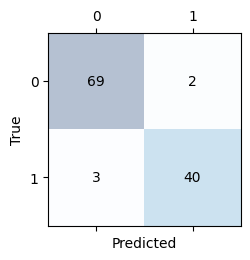

In [245]:
fig, ax = plt.subplots( figsize=(2.5,2.5) )
ax.matshow( conf_mat, cmap = plt.cm.Blues, alpha = 0.3 )
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text( x = i, y = j, s = conf_mat[i][j], va="center", ha="center" )

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [246]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

In [248]:
f1_score( y_true=y_test, y_pred=y_pred )

0.9411764705882353

In [251]:
from sklearn.metrics import make_scorer

In [253]:
scorer = make_scorer( score_func=f1_score )

### ROC Curve

In [ ]:
'''
    When trying to get the optimal choice for a specific hyperparameter,
    depending on the confusion matrix, we draw an ROC curve. By evaluating
    the true/false positives at different stages we obtain enough data to 
    scatter a plot that tells us how many of our samples are classified in the 
    right way.
'''

In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

In [10]:
from sklearn.metrics import roc_curve, auc

In [11]:
from numpy import interp

In [27]:
pipe_lr = make_pipeline( StandardScaler(), PCA( n_components=2 ), LogisticRegression( 
                          penalty="l2", C = 100, random_state=0, solver="lbfgs" ) )

In [28]:
X_train2 = X_train[:, [ 4, 14 ]]

In [31]:
cv = list(StratifiedKFold( n_splits = 3 ).split( X_train2, y_train ))

In [34]:
fig = plt.figure( figsize=(7,5) )

<Figure size 700x500 with 0 Axes>

In [38]:
all_tpr = []

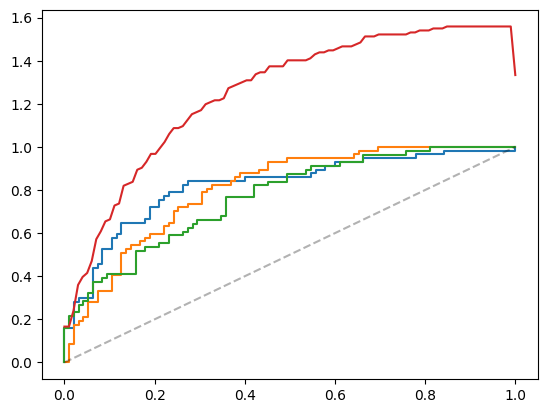

In [59]:
probs = []
for i, (train,test) in enumerate( cv ):
    probas = pipe_lr.fit( X_train2[train], y_train[train] ).predict_proba( X_train2[test] )
    fpr, tpr, thresholds = roc_curve( y_train[test], probas[:,1], pos_label=1 )
    mean_tpr += interp( mean_fpr, fpr, tpr )
    roc_auc = auc( fpr, tpr )
    plt.plot( fpr, tpr, label = f"ROC fold {i+1} (area : {roc_auc:.2f})" )

plt.plot( [0,1], [0,1], label = "Random Guessing", linestyle='--', alpha = 0.3, color = "black" )
mean_tpr = mean_tpr / len(cv)
mean_auc = auc( mean_fpr, mean_tpr )
plt.plot( mean_fpr, mean_tpr, label = f"mean auc area : {mean_auc:.2f}" )

In [60]:
from sklearn.metrics import make_scorer, precision_score

In [62]:
scorer1 = make_scorer( score_func = precision_score, pos_label = 1, greater_is_better=True, average="micro")

In [ ]:
'''
    When scoring a model with multicalss classification problem, we can use two
    methods for this job : `macro` & `micro`.

    micro : calculating each individual weight in the system.
    macro : taking the average of all systems.
'''

### Imbalanced Data.

In [69]:
x_imb = np.vstack( ( X[ y == 0], X[ y == 1][:40]) )

In [83]:
y_imb = np.hstack( ( y[ y == 0], y[ y == 1][:40]) )

In [85]:
from sklearn.utils import resample

In [92]:
x_imb[ y_imb == 1].shape

(40, 30)

In [93]:
x_imb[ y_imb == 0].shape

(357, 30)

In [100]:
x_upsampled, y_upsampled = resample( x_imb[y_imb == 1], y_imb[y_imb == 1], replace = True, 
                                   n_samples = x_imb[y_imb == 0].shape[0], random_state=0)

In [101]:
x_upsampled[ y_upsampled == 1 ].shape

(357, 30)

In [102]:
x_upsampled[ y_upsampled == 0 ].shape

(0, 30)

In [103]:
x_bal = np.vstack( ( X[ y == 0 ], x_upsampled ) )
y_bal = np.hstack( ( y[ y == 0 ], y_upsampled ) )

In [107]:
x_bal[ y_bal == 0 ].shape

(357, 30)

In [106]:
x_bal[ y_bal == 1 ].shape

(357, 30)

In [117]:
y_pred1 = np.zeros( y_bal.shape[0] )

In [120]:
np.mean( y_bal == y_pred1 )

0.5